Inrix data exploration

* truck types (VehicleWeightClass) - need to work with ProviderDetails.csv
* O-D
* Time of day

In [12]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pyodbc
import pymssql
import sqlalchemy
from shapely import wkt

In [2]:
#load the data
data_path = r'X:\Trans\Freight\Data\INRIXSample\TripBulkReport-tripBulk_20200813170926316_trip_paths_freight_usa_wa_everett_20150513'

#trajectories data
trajectories_header = pd.read_csv(os.path.join(data_path, 'schema', 'TripBulkReportTrajectoriesHeaders.csv'))
traj_df = pd.read_csv(os.path.join(data_path, 'data', 'trajs.csv'), names = trajectories_header.columns)

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#trips data
trips_header = pd.read_csv(os.path.join(data_path, 'schema', 'TripBulkReportTripsHeaders.csv'))
trips_df = pd.read_csv(os.path.join(data_path, 'data', 'trips.csv'), names = trips_header.columns)

In [4]:
#vehicle data
vehicle_header = pd.read_csv(os.path.join(data_path, 'schema', 'TripBulkReportProviderDetailsHeaders.csv'))
vehicle_df = pd.read_csv(os.path.join(data_path, 'schema', 'TripBulkReportProviderDetails.csv'), names = vehicle_header.columns)

In [14]:
#
#conn_string = "DRIVER={ODBC Driver 17 for SQL Server}; SERVER=AWS-PROD-SQL\Sockeye; DATABASE=ElmerGeo; trusted_connection=yes"
conn = pymssql.connect(server='AWS-PROD-SQL\Sockeye', database='ElmerGeo') 
#sql_conn = pyodbc.connect(conn_string)
df = pd.read_sql_query(sql='select * from dbo.TRACT2010', con=conn)

In [15]:
pd.df.head(10)

,OBJECTID,statefp10,countyfp10,tractce10,geoid10,name10,namelsad10,mtfcc10,funcstat10,aland10,awater10,intptlat10,intptlon10,name_val,Shape,GDB_GEOMATTR_DATA
0,1,53,033,022006,53033022006,220.06,Census Tract 220.06,G5020,S,1408907.0,0.0,+47.7043393,-122.1992667,220.0,b'\xed\x08\x00\x00\x01\x04\x97\x00\x00\x00@\'\...,None
1,2,53,033,032320,53033032320,323.20,Census Tract 323.20,G5020,S,9554873.0,38494.0,+47.7564769,-122.1244452,323.0,b'\xed\x08\x00\x00\x01\x04\xa7\x01\x00\x00@\xd...,None
2,3,53,033,031703,53033031703,317.03,Census Tract 317.03,G5020,S,7139218.0,643846.0,+47.3716888,-122.1484314,317.0,b'\xed\x08\x00\x00\x01\x04\xd7\x00\x00\x00@\\6...,None
3,4,53,033,031206,53033031206,312.06,Census Tract 312.06,G5020,S,3668962.0,60430.0,+47.3135621,-122.1835380,312.0,b'\xed\x08\x00\x00\x01\x04\xe3\x00\x00\x00\xc0...,None
4,5,53,033,032102,53033032102,321.02,Census Tract 321.02,G5020,S,79040166.0,84391.0,+47.4851508,-121.9657840,321.0,b'\xed\x08\x00\x00\x01\x04\xeb\x02\x00\x00\x00...,None
5,6,53,033,032210,53033032210,322.10,Census Tract 322.10,G5020,S,41801336.0,17075.0,+47.5512023,-121.9640526,322.0,b'\xed\x08\x00\x00\x01\x04\r\x03\x00\x00\x80\x...,None
6,7,53,033,032211,53033032211,322.11,Census Tract 322.11,G5020,S,2975633.0,0.0,+47.5798198,-122.0193627,322.0,b'\xed\x08\x00\x00\x01\x04\xb5\x00\x00\x00\x80...,None
7,8,53,033,032104,53033032104,321.04,Census Tract 321.04,G5020,S,22481612.0,0.0,+47.5051267,-122.0531593,321.0,b'\xed\x08\x00\x00\x01\x04\x02\x02\x00\x00\xc0...,None
8,9,53,033,032313,53033032313,323.13,Census Tract 323.13,G5020,S,13092990.0,436039.0,+47.6705089,-122.0890118,323.0,b'\xed\x08\x00\x00\x01\x04/\x01\x00\x00@\x13\x...,None
9,10,53,033,032203,53033032203,322.03,Census Tract 322.03,G5020,S,10073205.0,3779419.0,+47.5954699,-122.0694173,322.0,b'\xed\x08\x00\x00\x01\x04\x0c\x01\x00\x00\xc0...,None


In [5]:
def read_from_sde(connection_string, feature_class_name,
                  crs={'init': 'epsg:2285'}):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """

    engine = sqlalchemy.create_engine(connection_string)
    con=engine.raw_connection()
    feature_class_name = feature_class_name + '_evw'
    df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
    con.close()
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf=gpd.GeoDataFrame(df, geometry='geometry')
    gdf.crs = crs
    cols = [col for col in gdf.columns if col not in 
            ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
    
    return gdf[cols]

In [8]:
gdb_connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/OSMTest?driver=SQL Server?Trusted_Connection=yes'
name = 'ElmerGeo.DBO.tract2010'

In [13]:
df2 = read_from_sde(gdb_connection_string,name )

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

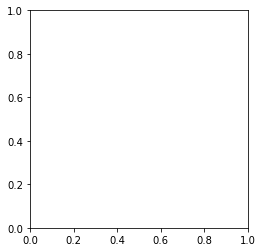

In [22]:
df2.plot()

In [9]:
pd.set_option('display.max_columns', None)
trips_df.head(10)


,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,EndLocLat,EndLocLon,GeospatialType,ProviderType,ProviderDrivingProfile,VehicleWeightClass,ProbeSourceType,OriginZoneName,DestinationZoneName,EndpointType,TripMeanSpeedKph,TripMaxSpeedKph,TripDistanceMeters,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk
0,078a0d3bc51bc9e533532cd25b75514c,68110726fea7b51fe1f4226264a04953,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T20:21:34.000Z,3,2015-05-13T21:05:15.000Z,3,47.97015,-122.19749,47.69820,-122.18513,EE,2,3,2,1,NaN,NaN,NaN,49.528603,102.321811,36059.574817,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,63.926829,21230030001121212,21230030201332211
1,4cdd98f6444eaf562ab5116eb0f4a588,b2398bbe366c8dc0563ab0f31688c0c2,1534b76d325a8f591b52d302e7181331,1,2015-05-13T22:30:17.000Z,3,2015-05-14T00:19:52.000Z,3,47.63994,-122.40211,48.00416,-122.06703,EE,2,3,2,1,NaN,NaN,NaN,30.361626,94.589136,55452.137076,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,134.183673,21230021313232123,21230012233221001
2,7e9f82bd802f2294285a539061fdaacc,fa7378c980efdc8b252f835db69123be,26657d5ff9020d2abefe558796b99584,1,2015-05-13T14:39:37.000Z,3,2015-05-13T16:36:40.000Z,3,48.09046,-122.18513,47.23775,-122.24418,EE,2,3,2,1,NaN,NaN,NaN,52.353350,94.240729,102132.660501,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,270.115385,21230012221130031,21230032201203200
3,967f3fa239897875e5e7fdfc52df3a80,b8c416dff599605491aa44412bcc56e1,6cdd60ea0045eb7a6ec44c54d29ed402,1,2015-05-13T23:17:39.000Z,3,2015-05-14T01:14:27.000Z,3,48.33023,-122.16316,47.65937,-122.33482,EE,2,3,2,1,NaN,NaN,NaN,51.804359,115.924988,100845.818852,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,113.032258,21230012030002211,21230030202200330
4,e7a1e285c024e7e875352e87e336395a,ca1e6fe91e4ad4cf350870eb278734f8,45c48cce2e2d7fbdea1afc51c7c6ad26,1,2015-05-13T20:02:28.000Z,3,2015-05-13T20:35:40.000Z,3,47.89654,-122.25379,48.12897,-122.17689,EE,2,4,3,1,NaN,NaN,NaN,52.841851,116.692279,29239.157739,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,48.585366,21230030003200203,21230012203313001
5,098bff1d1f9937a84c38eec732e9c16a,323a033752002ae223ebe2db2f4e13f6,1534b76d325a8f591b52d302e7181331,1,2015-05-13T20:33:24.000Z,3,2015-05-13T20:59:16.000Z,3,47.73424,-122.29637,47.90943,-122.22358,EE,2,3,2,1,NaN,NaN,NaN,63.046620,93.751077,27180.098291,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,86.222222,21230030200120212,21230030003030333
6,e29ed0b3da331b509a49b4feba5d28a9,bbe5b5abedc716e4f9cea8c8876a022d,6cdd60ea0045eb7a6ec44c54d29ed402,1,2015-05-13T19:14:57.000Z,3,2015-05-13T21:06:56.000Z,3,47.92508,-122.25517,47.56309,-122.36366,IE,2,3,2,1,polygon_usa_wa_everett_psrc,NaN,NaN,33.329207,106.331100,62205.261238,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,117.877193,21230030003000220,21230021333112221
7,f169fc48f6f6e75010af83d3bc5b4fe4,43d50b1f3ca0e4964992825bb2451e98,45c48cce2e2d7fbdea1afc51c7c6ad26,1,2015-05-13T21:12:31.000Z,3,2015-05-13T21:19:13.000Z,3,47.92324,-122.22633,47.93796,-122.25379,II,2,4,3,1,polygon_usa_wa_everett_psrc,polygon_usa_wa_everett_psrc,NaN,24.012497,23.966638,2681.395506,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,201.000000,21230030003012101,21230030001222001
8,f709a7b874b4444ebab67d122fd7a623,526ecbcb78ba477d321bb334ec825fe8,a597e50502f5ff68e3e25b9114205d4a,1,2015-05-13T14:46:49.000Z,3,2015-05-13T15:08:28.000Z,3,47.97751,-122.18788,47.97751,-122.18788,EE,2,3,2,1,NaN,NaN,NaN,32.533991,93.304878,11739.348488,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,144.333333,21230030001112203,21230030001112203
9,3a94e7249af7582450b7fd4b35ab4828,7650460a2d2e468d109544681c5571a6,f033ab37c30201f73f142449d037028d,1,2015-05-13T22:06:46.000Z,3,2015-05-13T22:22:53.000Z,3,47.92508,-122.21672,47.88181,-122.23045,IE,2,3,2,1,polygon_usa_wa_everett_psrc,NaN,NaN,27.985473,86.255557,7517.209014,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,42.043478,21230030003011320,21230030003230212


In [10]:
# select 
vehicle_df.groupby('VehicleWeightClass').count()

,ProviderId,ProviderType,ProviderDrivingProfile,ProbeSourceType
VehicleWeightClass,,,,
Heavy Duty Trucks: > 26000 lb.,16,16,16,16
Light Duty Truck/Passenger Vehicle: Ranges from 0 to 14000 lb.,115,115,115,115
Medium Duty Trucks / Vans: ranges from 14001-26000 lb.,64,64,64,64


In [34]:
vehicle_df.dtypes

ProviderId                object
ProviderType              object
ProviderDrivingProfile    object
VehicleWeightClass        object
ProbeSourceType           object
dtype: object

In [11]:
#join trips data and vehicle data

trips_vehicle = pd.merge(trips_df,vehicle_df, on='ProviderId')

In [12]:
trips_vehicle.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,EndLocLat,EndLocLon,GeospatialType,ProviderType_x,ProviderDrivingProfile_x,VehicleWeightClass_x,ProbeSourceType_x,OriginZoneName,DestinationZoneName,EndpointType,TripMeanSpeedKph,TripMaxSpeedKph,TripDistanceMeters,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk,ProviderType_y,ProviderDrivingProfile_y,VehicleWeightClass_y,ProbeSourceType_y
0,078a0d3bc51bc9e533532cd25b75514c,68110726fea7b51fe1f4226264a04953,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T20:21:34.000Z,3,2015-05-13T21:05:15.000Z,3,47.97015,-122.19749,47.69820,-122.18513,EE,2,3,2,1,NaN,NaN,NaN,49.528603,102.321811,36059.574817,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,63.926829,21230030001121212,21230030201332211,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS
1,17f366d8cca6563c1b7cadb291701314,e62ae3e2f7b9b848a6804b7b82ca853b,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T15:13:36.000Z,3,2015-05-13T15:26:12.000Z,3,47.90391,-122.20573,47.99497,-122.19200,EE,2,3,2,1,NaN,NaN,NaN,53.776768,97.920450,11293.121302,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,68.727273,21230030003122302,21230012223323130,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS
2,8e5d6399a3079f84f6cc4420f90f1a36,6446629a6063095fa9e6f235678facc2,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T05:56:51.000Z,2,2015-05-13T06:44:56.000Z,2,47.69913,-122.18513,47.93612,-122.20024,EI,2,3,2,1,NaN,polygon_usa_wa_everett_psrc,NaN,47.557702,102.516653,38112.214003,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,73.974359,21230030201332033,21230030001323020,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS
3,0aa3e15826085e63bd13fe685a8ac69d,0845fcf7c3c3480d7ac144570e8c60f9,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T03:45:33.000Z,2,2015-05-13T06:11:04.000Z,2,48.11339,-122.14393,47.16124,-120.84892,EE,2,3,2,1,NaN,NaN,NaN,78.397697,102.159220,190136.191991,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,91.905263,21230012212232003,21230122203222220,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS
4,95f583663242d5085857c93ce3e9dac1,635cf27092070c0665ca76fe8a0edad2,54229abfcfa5649e7003b83dd4755294,1,2015-05-13T22:01:30.000Z,3,2015-05-13T22:46:05.000Z,3,47.81269,-122.23594,47.93704,-122.30735,EE,2,3,2,1,NaN,NaN,NaN,32.759410,100.210403,24342.061795,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,83.593750,21230030023001110,21230030000233012,fleet,Field Service / Local Delivery Fleets,Medium Duty Trucks / Vans: ranges from 14001-2...,EmbeddedGPS


In [13]:
g_o_trips_vehicle = geopandas.GeoDataFrame(
    trips_vehicle, geometry=geopandas.points_from_xy(trips_vehicle.StartLocLon, trips_vehicle.StartLocLat))

In [40]:
g_o_trips_vehicle.crs = "EPSG:3857"

In [41]:
g_o_trips_vehicle = g_o_trips_vehicle.to_crs(epsg=3857)

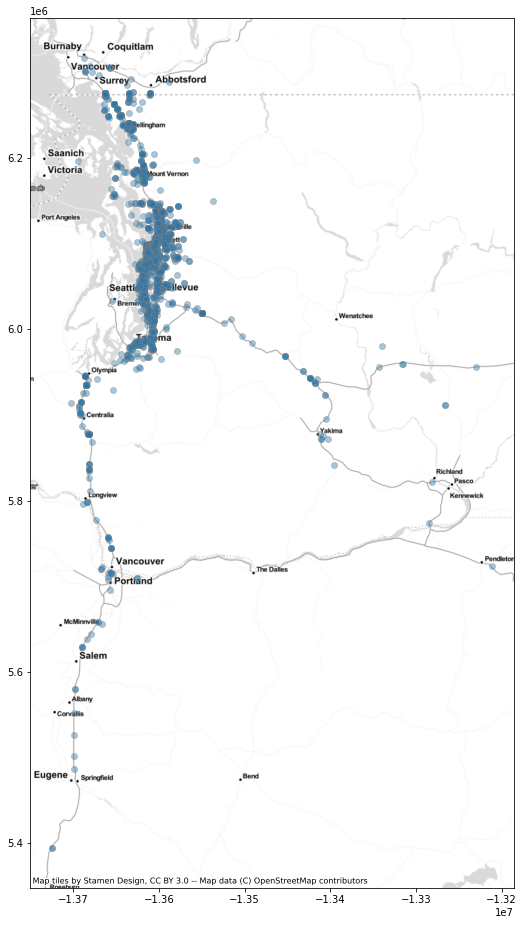

In [46]:
ax = g_o_trips_vehicle.plot(figsize=(9, 16), zorder=10, ec='gray', alpha=0.4)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)


In [43]:
src_basemap = ctx.providers.Stamen.Terrain
ctx.add_basemap( ax, source=src_basemap,  zoom='auto' )

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

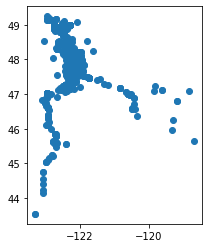

In [23]:
g_o_trips_vehicle.plot()

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


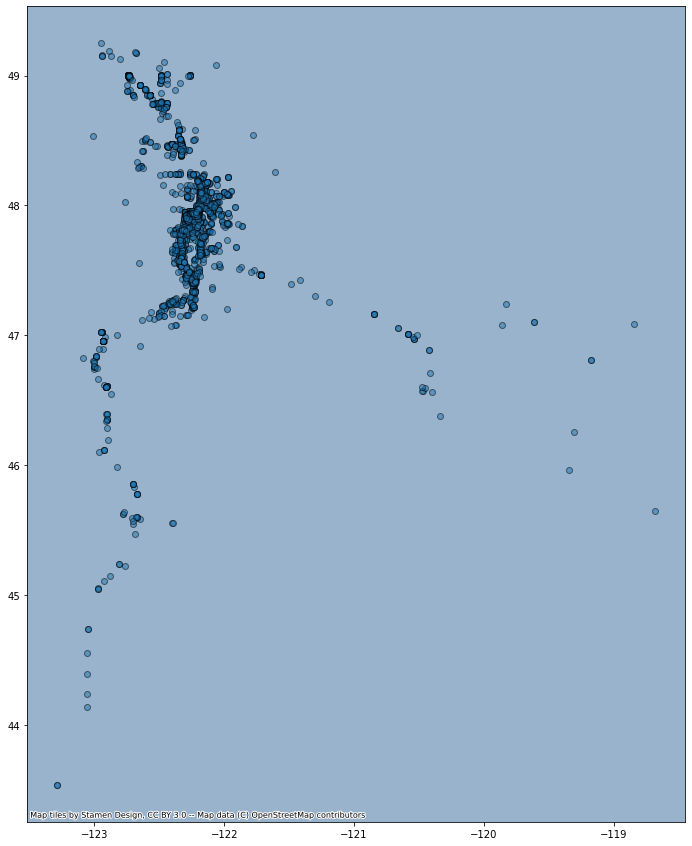

In [31]:
ax = g_o_trips_vehicle.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)


C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  
C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


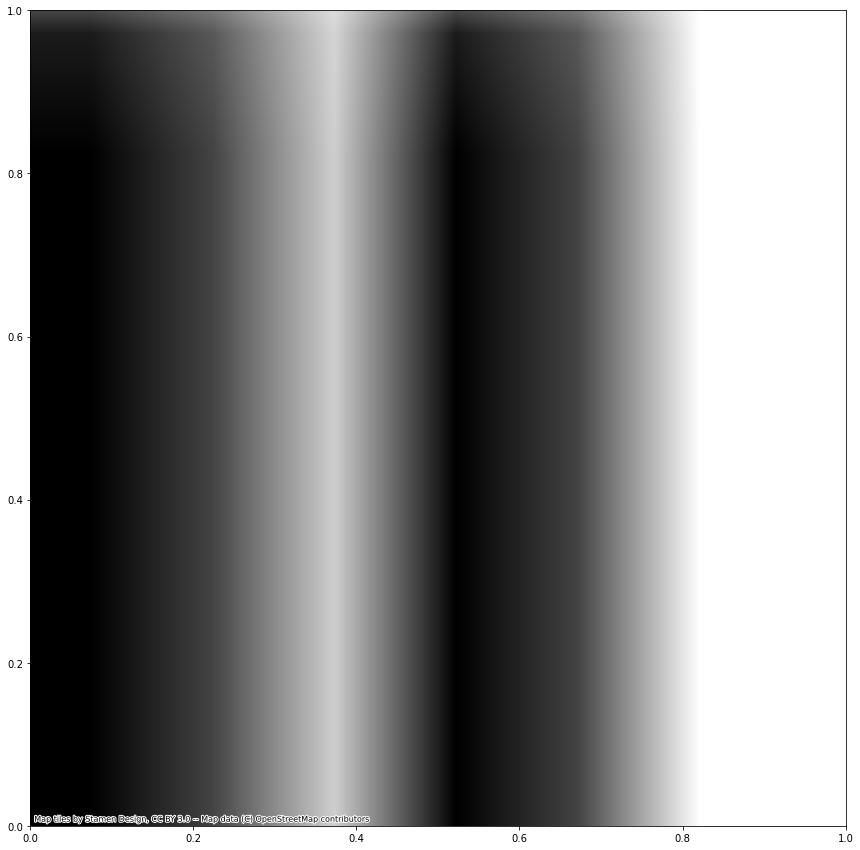

In [32]:
fig, ax = plt.subplots(figsize=(15,15))
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

In [43]:
trips_summary = pd.DataFrame(traj_df['SegmentId'].value_counts())
trips_summary.reset_index(inplace = True)
trips_summary = trips_summary.rename(columns={"SegmentId": "trips", "index": "SegmentId"})


In [44]:
i_trips = trips_summary[~trips_summary['SegmentId'].str.contains('-')]
i_trips = i_trips.rename(columns={"trips" : "trips_i"})



In [45]:
j_trips = trips_summary[trips_summary['SegmentId'].str.contains('-')]
j_trips['SegmentId'] = j_trips['SegmentId'].str[1:]
j_trips = j_trips.rename(columns={"trips" : "trips_j"})

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
trips_summary

,SegmentId,trips
0,25794567_1,984
1,25794567_0,982
2,35134231_0,980
3,623704138_0,980
4,623704131_0,980
...,...,...
85876,-6142261_42,1
85877,6141851_7,1
85878,6126544_8,1
85879,376779005_0,1
